In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [70]:
transform = transforms.Compose([
    transforms.ToTensor(),transforms.Grayscale()
])

In [71]:
train_set = datasets.CIFAR10(
    root="./data/CIFAR10",
    train = True,
    transform=transform,
    download=True
)

test_set = datasets.CIFAR10(
    root="./data/CIFAR10",
    train = False,
    transform = transform,
    download = True
)

train_size = int(len(train_set)*0.9)
val_size = len(train_set)-train_size
train_set,val_set = torch.utils.data.random_split(train_set,[train_size,val_size])

batch_size=128

train_loader = DataLoader(train_set,batch_size,True)
val_loader = DataLoader(val_set,batch_size,True)
test_loader = DataLoader(test_set,batch_size,True)

/Users/sreesai/Learning/DeepLearning/.venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [72]:
train_set[0]

(tensor([[[0.5543, 0.5461, 0.5275,  ..., 0.6053, 0.6193, 0.6198],
          [0.5773, 0.5824, 0.5631,  ..., 0.6350, 0.6428, 0.6394],
          [0.5905, 0.5863, 0.5670,  ..., 0.6445, 0.6428, 0.6355],
          ...,
          [0.8875, 0.8820, 0.8831,  ..., 0.8584, 0.8623, 0.8588],
          [0.8938, 0.8859, 0.8898,  ..., 0.8715, 0.8692, 0.8658],
          [0.8966, 0.8926, 0.9000,  ..., 0.8824, 0.8780, 0.8755]]]),
 7)

In [73]:
class simple_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,64,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.maxp = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(128,128,kernel_size=3,padding=1,stride=2)
        self.conv6 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv7 = nn.Conv2d(128,256,kernel_size=3,padding=1,stride=2)
        self.fc1 = nn.Linear(256,128)
        self.fc2 = nn.Linear(128,10)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.drop = nn.Dropout(0.5)
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxp(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [58]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    val_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return val_loss,accuracy

In [59]:
def train_one_epoch(model,optimizer,criterion,loader,device):
    model.train()
    running_loss = 0.0

    for images,labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs=model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss/len(loader.dataset)
    return epoch_loss       

In [60]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
model = simple_cnn().to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr = 1e-3,
)

Using device: mps
simple_cnn(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-0

In [61]:
num_epochs = 15

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model=model,loader=train_loader,
        optimizer=optimizer,criterion=criterion,
        device=device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/15] Train Loss: 1.3859 Val Loss: 1.1218 Val Acc: 0.5926
Epoch [2/15] Train Loss: 0.9579 Val Loss: 1.0140 Val Acc: 0.6482
Epoch [3/15] Train Loss: 0.7862 Val Loss: 0.7788 Val Acc: 0.7188
Epoch [4/15] Train Loss: 0.6657 Val Loss: 0.8502 Val Acc: 0.7024
Epoch [5/15] Train Loss: 0.5625 Val Loss: 0.6706 Val Acc: 0.7698
Epoch [6/15] Train Loss: 0.4883 Val Loss: 0.6614 Val Acc: 0.7714
Epoch [7/15] Train Loss: 0.4229 Val Loss: 0.8146 Val Acc: 0.7382
Epoch [8/15] Train Loss: 0.3673 Val Loss: 0.6347 Val Acc: 0.8006
Epoch [9/15] Train Loss: 0.3078 Val Loss: 0.7007 Val Acc: 0.7826
Epoch [10/15] Train Loss: 0.2647 Val Loss: 0.6423 Val Acc: 0.8042
Epoch [11/15] Train Loss: 0.2228 Val Loss: 0.6428 Val Acc: 0.8022
Epoch [12/15] Train Loss: 0.1856 Val Loss: 0.6487 Val Acc: 0.8102
Epoch [13/15] Train Loss: 0.1575 Val Loss: 0.7249 Val Acc: 0.8066
Epoch [14/15] Train Loss: 0.1301 Val Loss: 0.7166 Val Acc: 0.8186
Epoch [15/15] Train Loss: 0.1158 Val Loss: 0.7431 Val Acc: 0.8190


In [63]:
class cnn_activ(simple_cnn):
    def forward(self,x):
        activations = {}
        activations["og"]=x
        x = F.relu(self.bn1(self.conv1(x)))
        activations["conv1"] = x
        x = F.relu(self.bn2(self.conv2(x)))
        activations["conv2"] = x
        x = F.relu(self.bn3(self.conv3(x)))
        activations["conv3"] = x
        x = self.maxp(x)
        activations["max"] = x
        x = F.relu(self.bn4(self.conv4(x)))
        activations["conv4"] = x
        x = F.relu(self.bn5(self.conv5(x)))
        activations["conv5"] = x
        x = F.relu(self.bn6(self.conv6(x)))
        activations["conv6"] = x
        x = F.relu(self.bn7(self.conv7(x)))
        activations["conv7"] = x
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x,activations

In [ ]:
import math
def visualize_feature_maps(model, image, device="mps", num_maps=16):
model.eval()
image = image.unsqueeze(0).to(device)

# Assuming your model returns (output, activations_dict)
_, activations = model(image)

for name, act in activations.items():
act = act.cpu().detach()
# Determine actual number of maps to show
total_maps = min(num_maps, act.shape[1])
# Calculate grid dimensions (e.g., 4x4 for 16 maps)
cols = int(math.sqrt(total_maps))
rows = math.ceil(total_maps / cols)

# Increase figsize for better detail (e.g., 15x15 or larger)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
fig.suptitle(f"Layer: {name}", fontsize=16)
# Flatten axes if there's more than one row/column
axes = axes.flatten() if total_maps > 1 else [axes]

for i in range(total_maps):
# Using 'viridis' or 'magma' often shows detail better than grayscale
axes[i].imshow(act[0, i], interpolation='nearest')
axes[i].axis("off")
axes[i].set_title(f"Map {i}", fontsize=10)

# Hide any unused subplots in the grid
for j in range(i + 1, len(axes)):
axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

In [ ]:

import math

def visualize_feature_maps(model, image, device=None, num_maps=16):
    """
    Visualizes the feature maps of a model.
    Note: This assumes the model's forward pass returns (output, activations_dict).
    """
    # Auto-detect device if not provided
    if device is None:
        device = "mps" if torch.backends.mps.is_available() else \
                 "cuda" if torch.cuda.is_available() else "cpu"
    
    model.to(device)
    model.eval()
    
    # Prepare image (add batch dimension)
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        # Assuming your model returns (output, activations_dict)
        _, activations = model(image)

    for name, act in activations.items():
        # Move to CPU and remove from computation graph
        act = act.cpu().detach()
        
        # Determine actual number of maps to show (don't exceed available channels)
        total_maps = min(num_maps, act.shape[1])
        
        # Calculate grid dimensions
        cols = int(math.sqrt(total_maps))
        rows = math.ceil(total_maps / cols)

        # Increase figsize for better detail
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        fig.suptitle(f"Layer: {name}", fontsize=16)
        
        # Flatten axes if there's more than one subplot
        if total_maps > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for i in range(total_maps):
            # Using 'viridis' provides better contrast for activation levels
            axes[i].imshow(act[0, i], cmap='viridis', interpolation='nearest')
            axes[i].axis("off")
            axes[i].set_title(f"Map {i}", fontsize=10)

        # Hide any unused subplots in the grid
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
        plt.show()

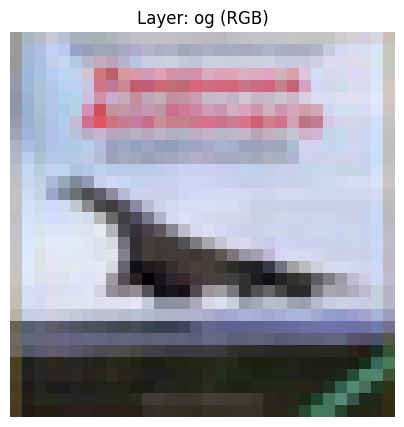

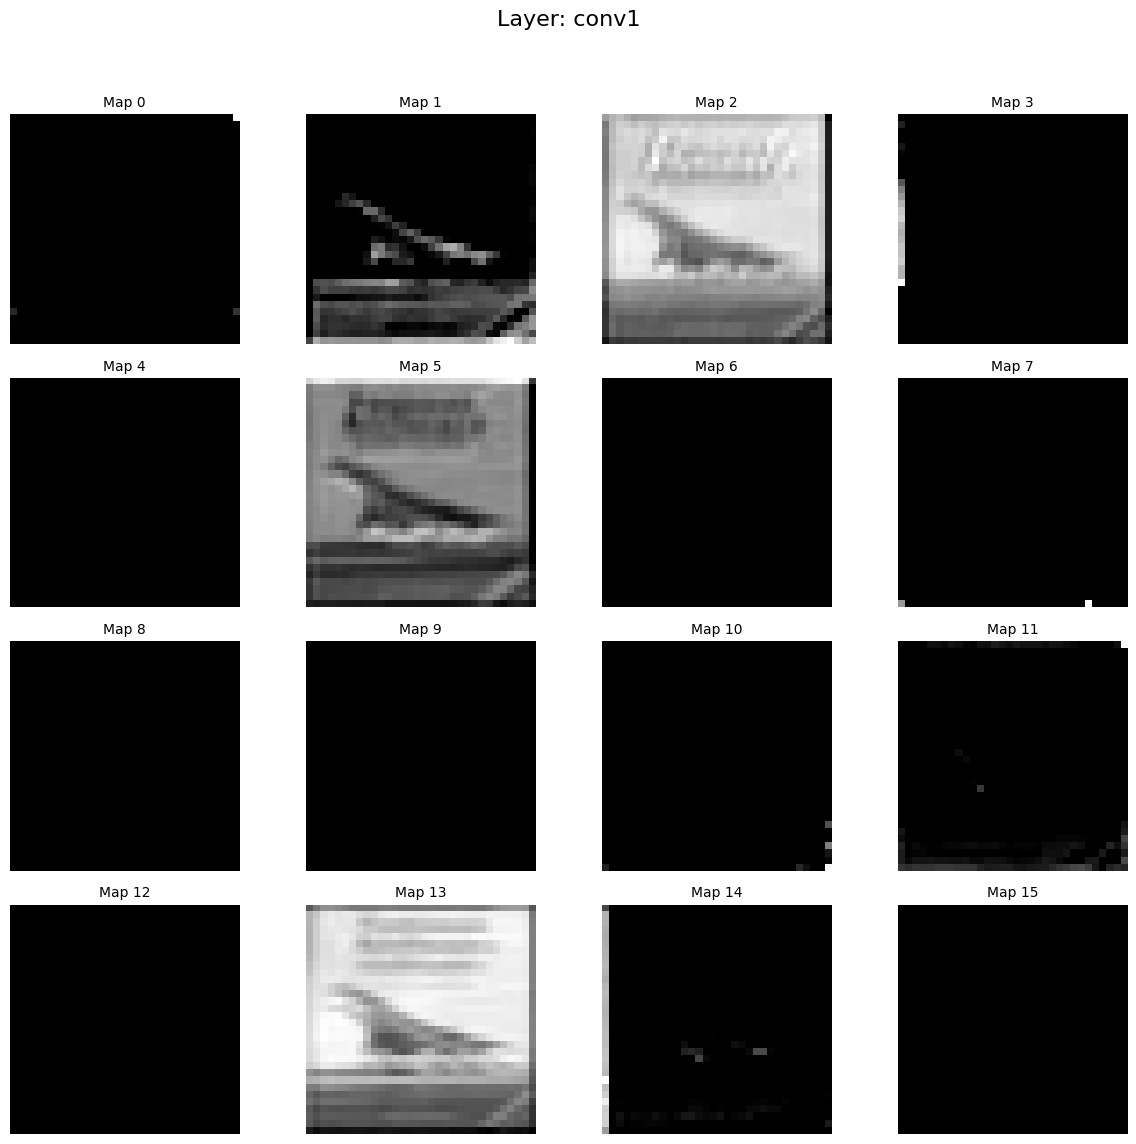

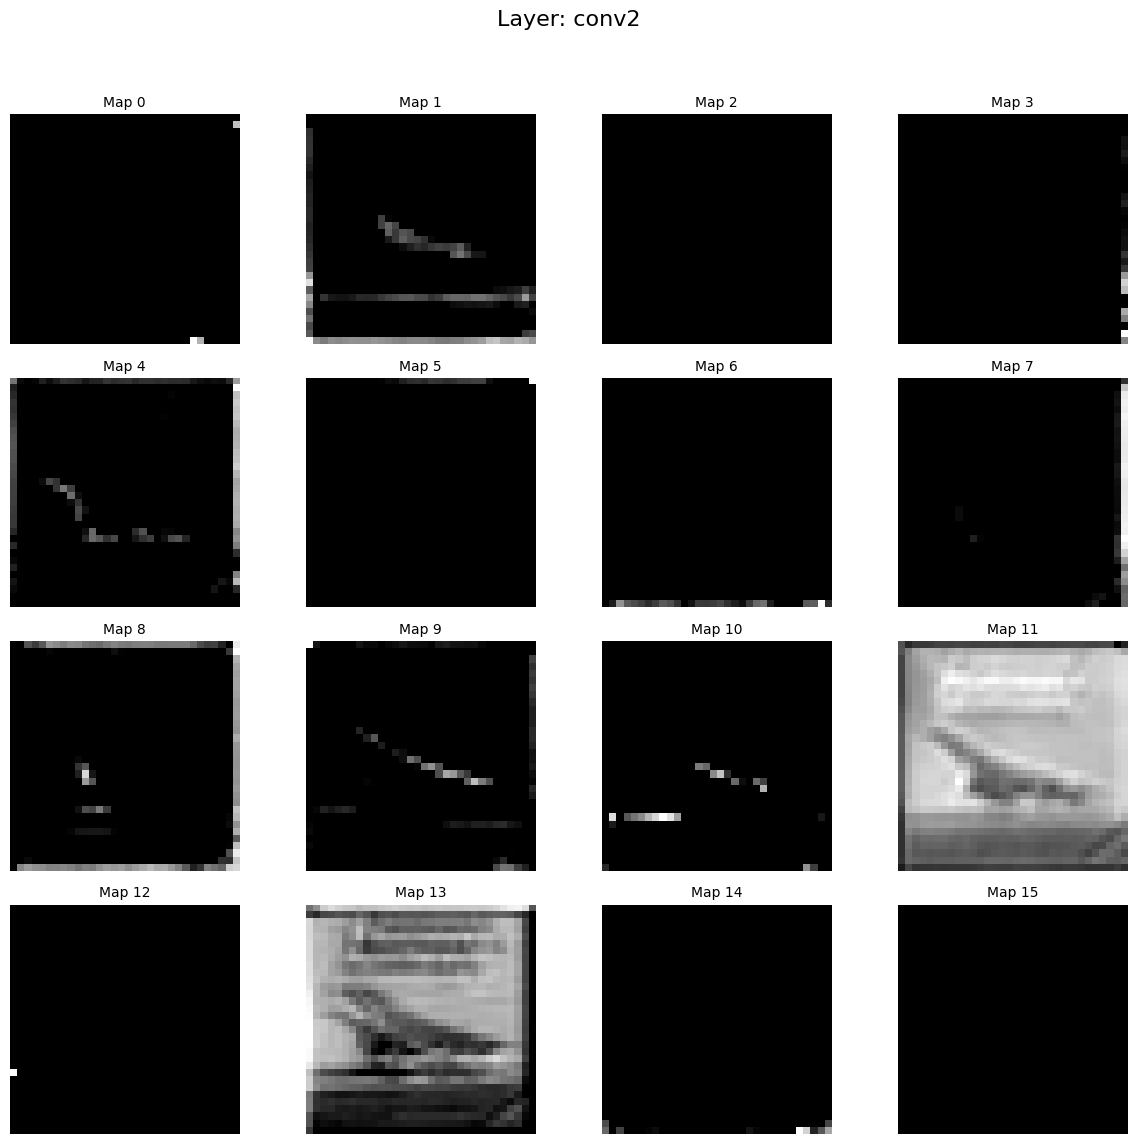

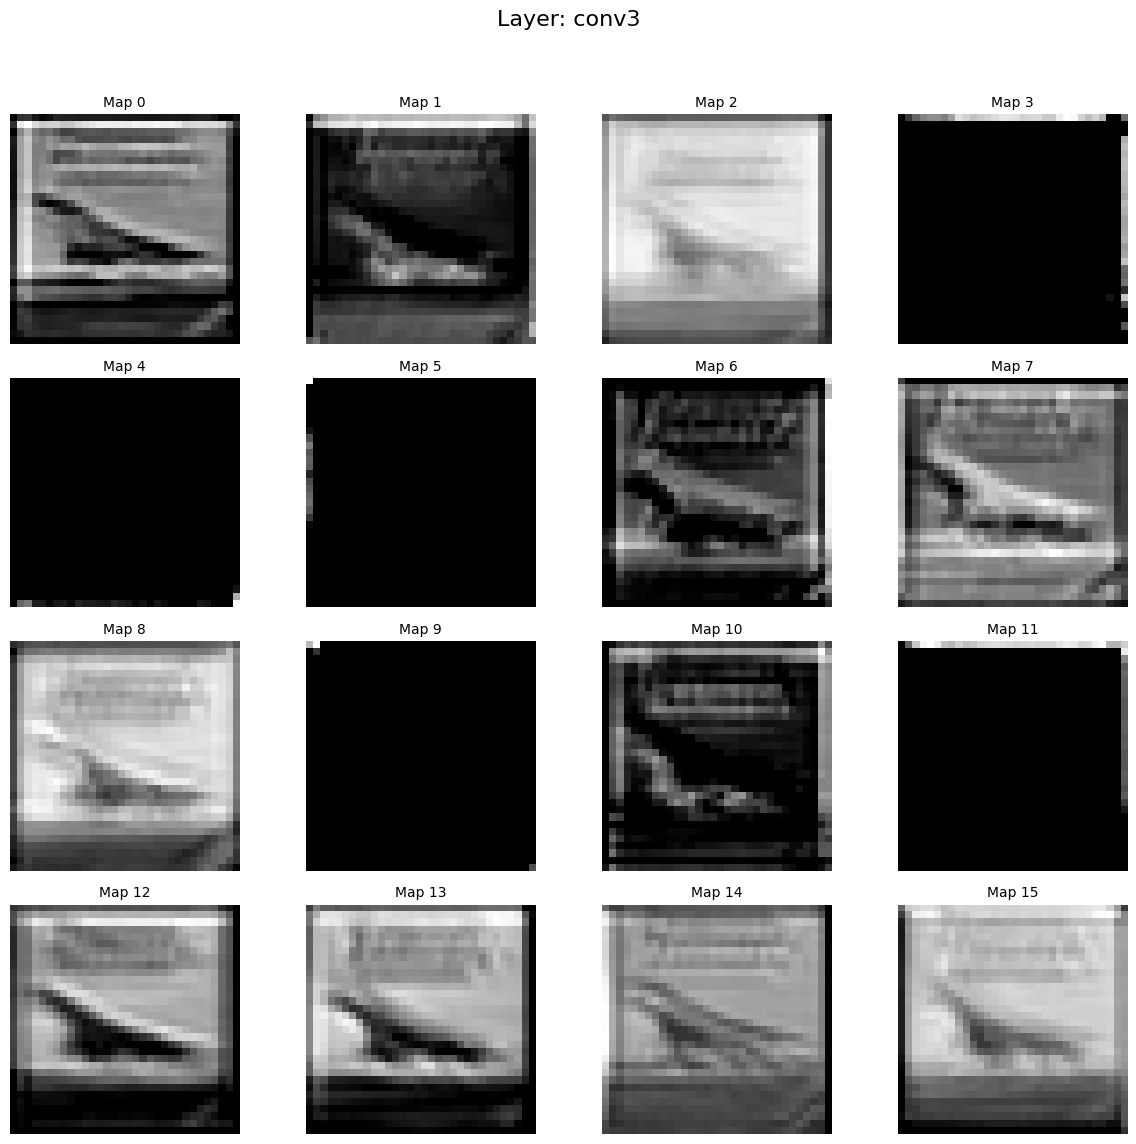

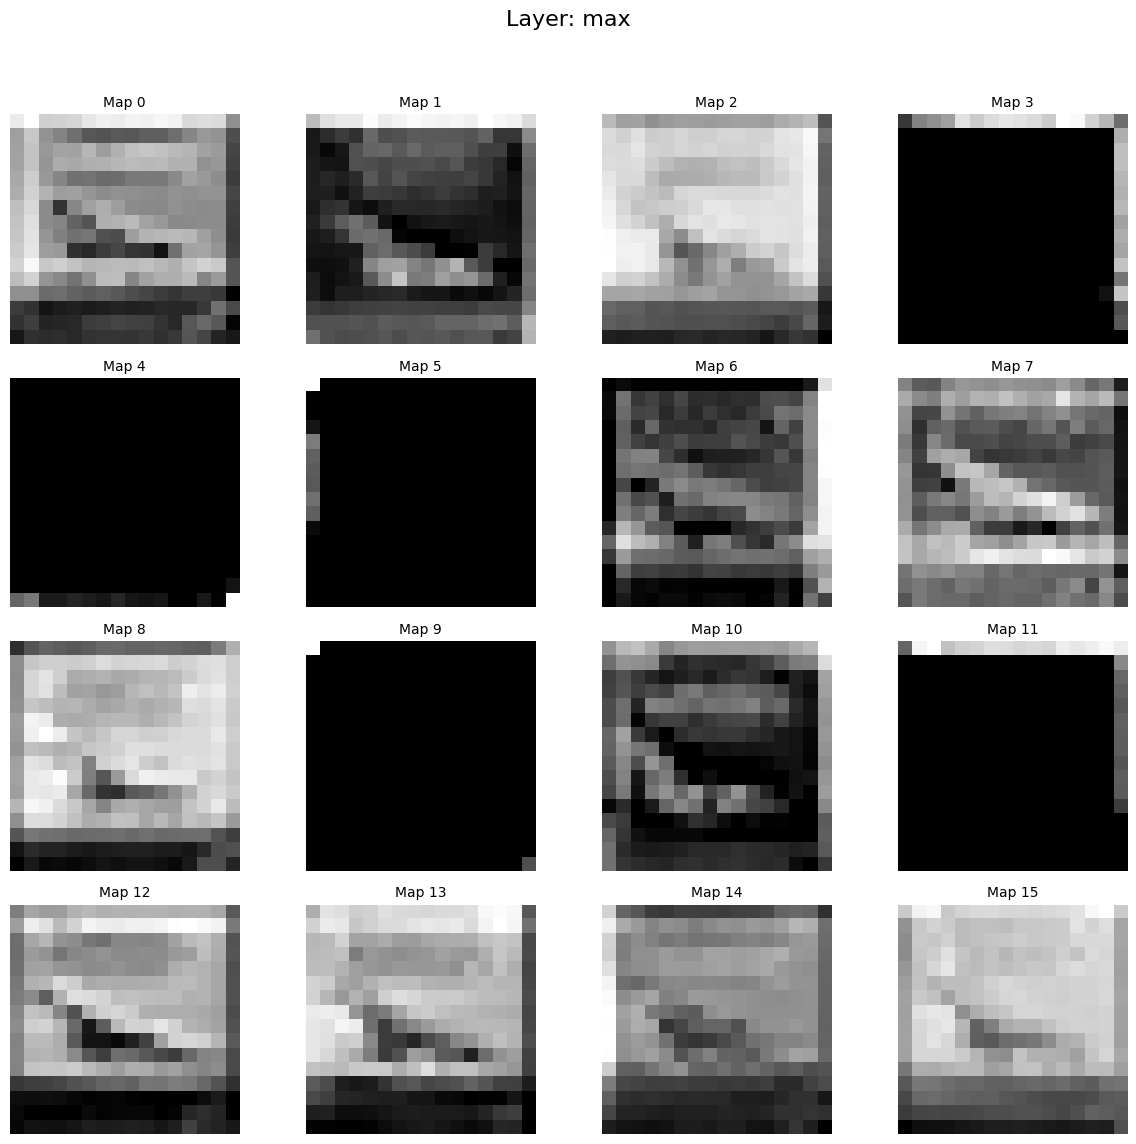

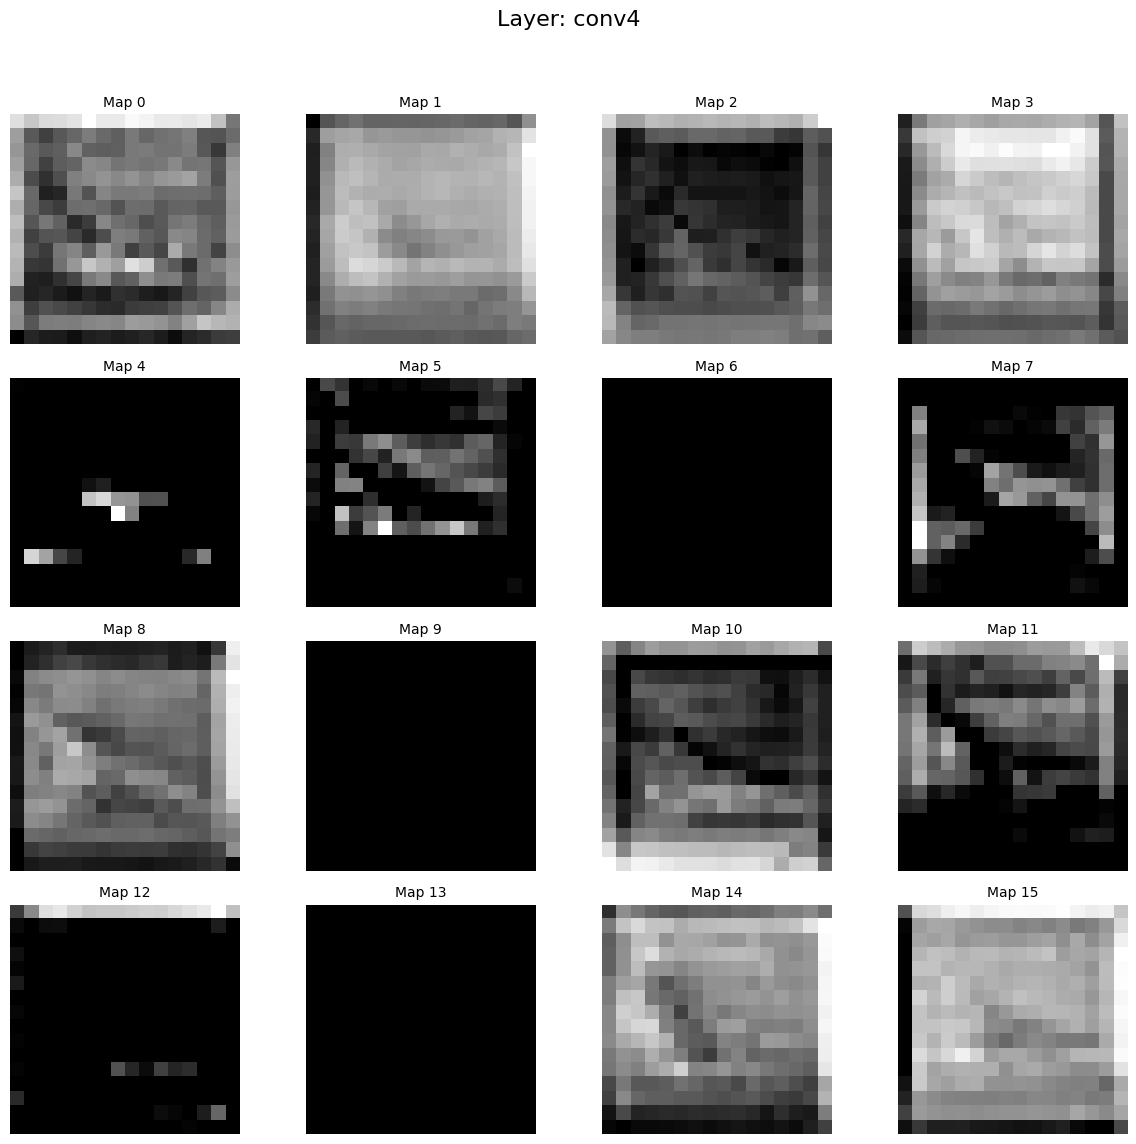

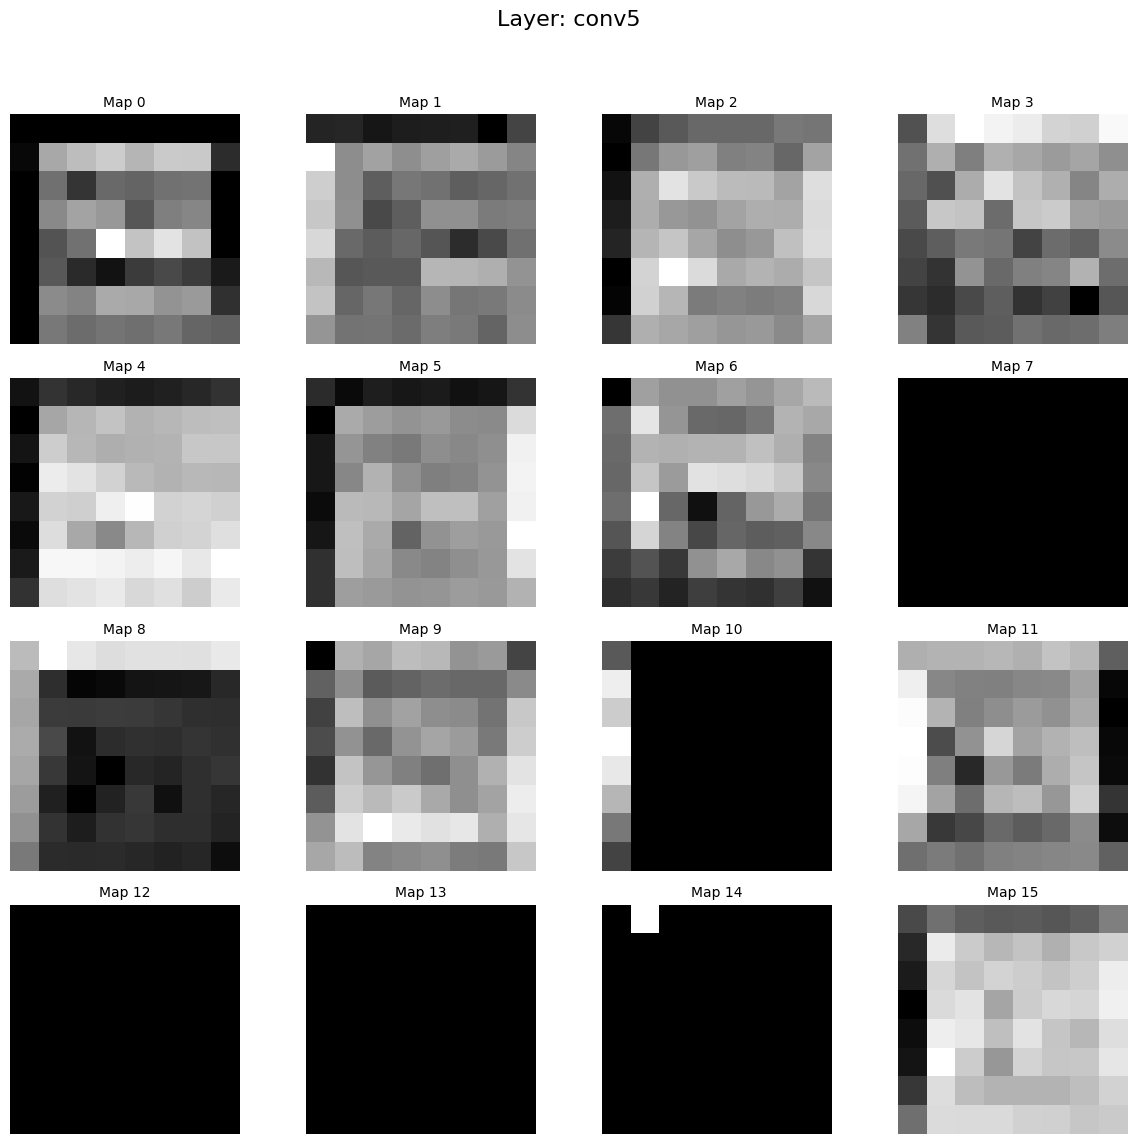

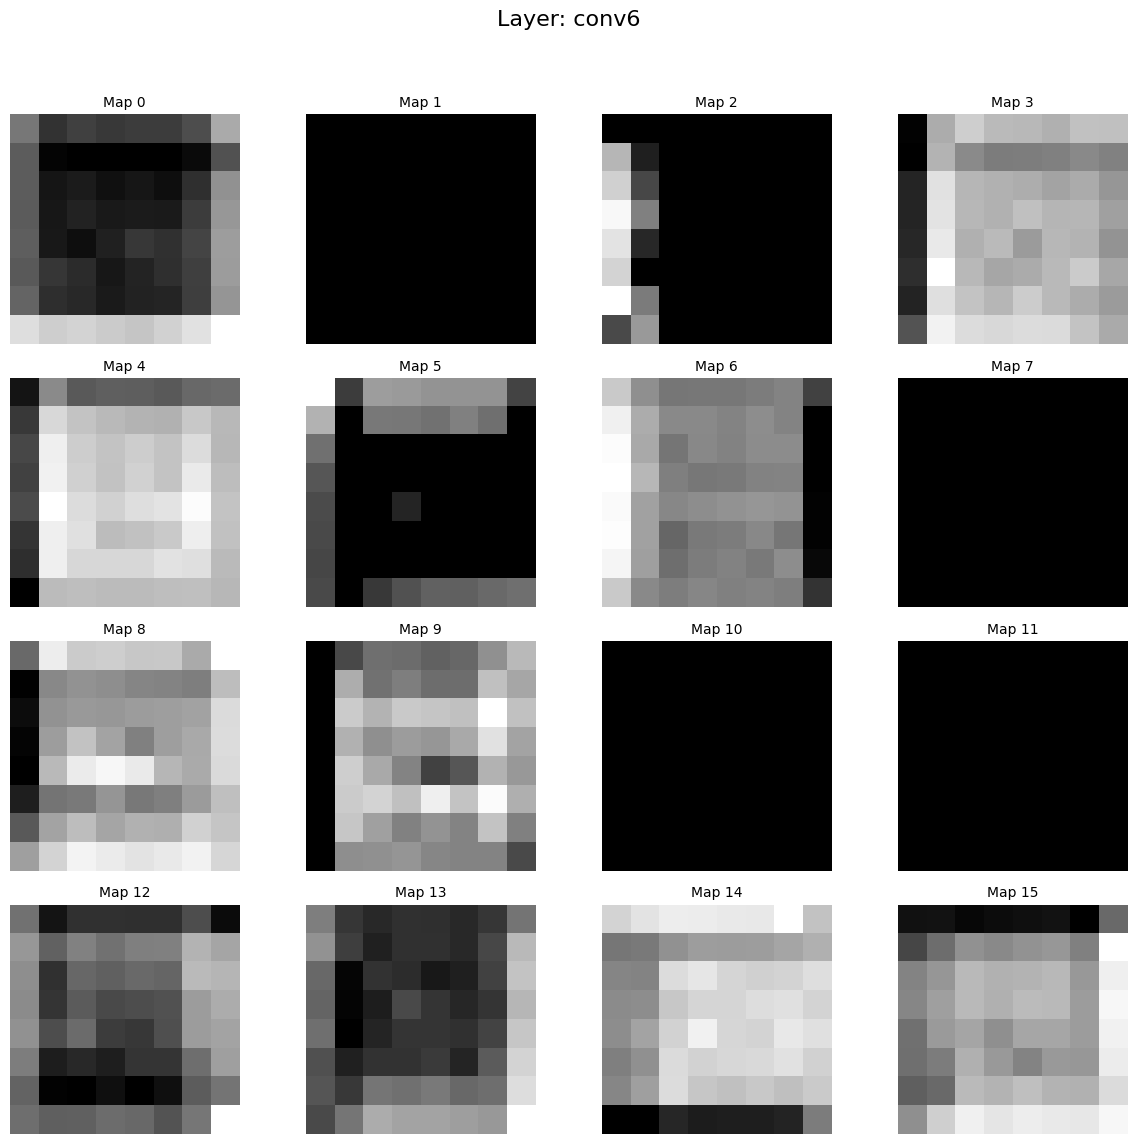

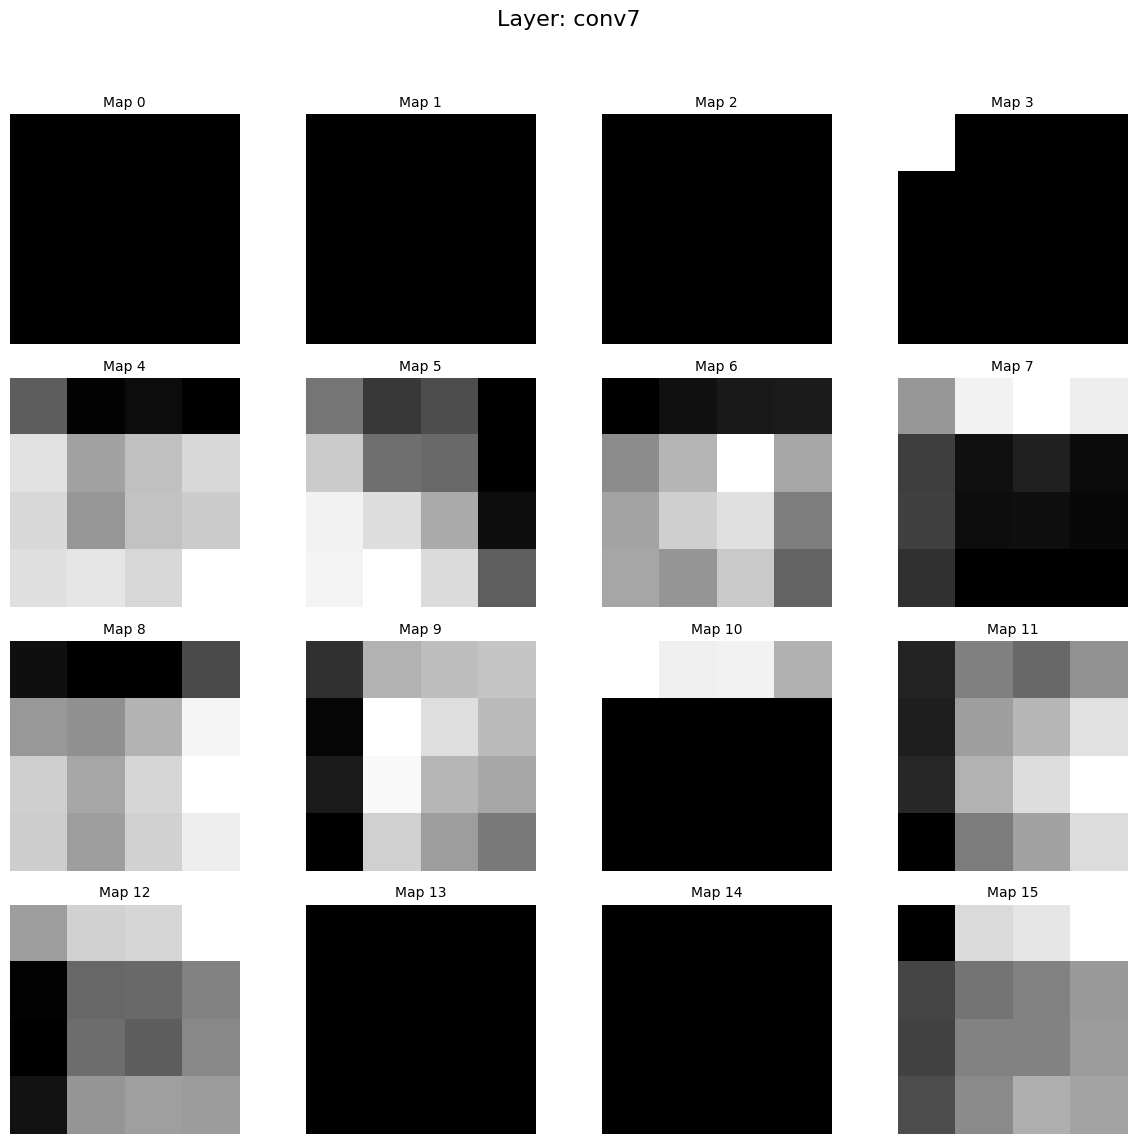

In [69]:
cnn_with_activations = cnn_activ().to(device)

sample_img, label = test_set[3]
visualize_feature_maps(cnn_with_activations,sample_img,device=device)

: 